<a href="https://colab.research.google.com/github/ShriShalini/Time-Series-Forecasting/blob/main/n_beats_exreme_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
! pip install darts

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
series_ai = pd.read_csv('/content/ai_count_no_ouliers.csv')


In [28]:
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
scaler_ai_retweet = Scaler()

series_ai_count = scaler_ai_retweet.fit_transform(
        TimeSeries.from_dataframe(
            series_ai, 'date', ['count'])
    ) 
#series_ai_count.plot(label ='count')
#plt.xlabel('date')
#plt.ylabel('tweet_count')
#fig1 = plt.gcf()
#plt.legend();
#plt.show()
#fig1.savefig('tweet_count.png')

In [29]:
train_tweet_count, val_tweet_count = series_ai_count.split_after(pd.Timestamp('20200930'))

In [30]:
import torch

In [31]:
def extreme_true(pred,true):
  #define the hi_th anf lw_th
  hi_th = 0.65
  lw_th = 0.2
  if (pred>hi_th or pred <lw_th)  and (true <= hi_th and true >=lw_th):
    return True
  elif (true>hi_th or true <lw_th)  and (pred <= hi_th and pred >=lw_th):
    return True
  else:
    return False  
    


In [32]:
def extreme_tensor(pred_tensor,true_tensor):
  hi_th = 0.65
  lw_th = 0.2
  high_tensor = torch.full((pred_tensor.size[0],pred_tensor.size[1],pred_tensor.size[2]), hi_th)
  lw_tensor = torch.full((pred_tensor.size[0],pred_tensor.size[1],pred_tensor.size[2]), hi_th)
  #compare the pred with the high and low_tensor
  pred_comp_hi = torch.tensor.gt(pred_tensor,high_tensor)
  pred_comp_lw = torch.tensor.le(pred_tensor,lw_tensor)
  
  # an or to know if it is extreme or not  
  extreme_pred = torch.logical_or(pred_comp_hi,pred_comp_lw)
  #compare the true with the high and low
  true_comp_hi = torch.tensor.gt(true_tensor,high_tensor)
  true_comp_lw = torch.tensor.le(true_tensor,lw_tensor)
  
  # an and to know if it is extreme or not
  extreme_true = torch.logical_and(true_comp_hi,true_comp_lw)
  #get the and of the 2 above
  
  extreme_final = torch.logical_and(extreme_pred,extreme_true)

  #get the diff from the pred and true



  # change the values of the true and false to the hyperparamters of the loss



  # do multiplication of the 2 above 




In [38]:
 def ExtremeLoss(preds, true):
   # define the upper and the lower thresholds
  loss = list(range(0,preds.shape[0]))
   # 1st loop for the batch
  batch_counter =0  
  for pred in preds:
    
     #pred is a tensor of 7 dimsneions 
     #2nd loop for dims in the tensor
     dim_counter = -1 
     for dim in pred :
       dim_counter +=1
       if extreme_true(dim,true[batch_counter][dim_counter] ) == True:
        # extreme loss
          loss[batch_counter] += (dim - true[batch_counter][dim_counter])*100
       else:
        #simple loss
          loss[batch_counter] += (dim - true[batch_counter][dim_counter])/16 

     batch_counter +=1
  loss_tensor = torch.tensor(loss, requires_grad= True)
  #print(torch.sum(loss_tensor)) 
  return torch.sum(loss_tensor)

In [33]:
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape

In [39]:
model_ai = NBEATSModel(input_chunk_length=60, output_chunk_length=7, n_epochs=300, random_state=0,
                                          loss_fn = ExtremeLoss )
model_ai.fit([train_tweet_count],val_series = [val_tweet_count], verbose=True)
pred_ai = model_ai.predict(n=88, series = train_tweet_count )
#pred_follower = model_ai_multiple.predict(n=36, series = train_follower )
error_tweet = mape(val_tweet_count[:88],pred_ai)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the tweet_count:",error_tweet )

[2021-11-30 08:13:29,207] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-11-30 08:13:29,207] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-11-30 08:13:29,298] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-11-30 08:13:29,298] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 1/300 [00:00<01:56,  2.56it/s]

  4%|▎         | 11/300 [00:03<01:42,  2.83it/s]

  7%|▋         | 21/300 [00:07<01:38,  2.84it/s]

 10%|█         | 31/300 [00:10<01:36,  2.79it/s]

 14%|█▎        | 41/300 [00:14<01:31,  2.82it/s]

 17%|█▋        | 51/300 [00:17<01:29,  2.78it/s]

 20%|██        | 61/300 [00:21<01:27,  2.72it/s]

 24%|██▎       | 71/300 [00:24<01:23,  2.74it/s]

 27%|██▋       | 81/300 [00:28<01:18,  2.78it/s]

 30%|███       | 91/300 [00:31<01:13,  2.82it/s]

 34%|███▎      | 101/300 [00:35<01:11,  2.76it/s]

 37%|███▋      | 111/300 [00:38<01:06,  2.85it/s]

 40%|████      | 121/300 [00:42<01:04,  2.79it/s]

 44%|████▎     | 131/300 [00:45<00:59,  2.82it/s]

 47%|████▋     | 141/300 [00:49<00:56,  2.83it/s]

 50%|█████     | 151/300 [00:52<00:53,  2.79it/s]

 54%|█████▎    | 161/300 [00:56<00:50,  2.74it/s]

 57%|█████▋    | 171/300 [00:59<00:46,  2.79it/s]

 60%|██████    | 181/300 [01:03<00:42,  2.78it/s]

 64%|██████▎   | 191/300 [01:06<00:39,  2.78it/s]

 67%|██████▋   | 201/300 [01:10<00:34,  2.83it/s]

 70%|███████   | 211/300 [01:13<00:32,  2.76it/s]

 74%|███████▎  | 221/300 [01:17<00:28,  2.82it/s]

 77%|███████▋  | 231/300 [01:20<00:24,  2.78it/s]

 80%|████████  | 241/300 [01:24<00:21,  2.73it/s]

 84%|████████▎ | 251/300 [01:28<00:17,  2.75it/s]

 87%|████████▋ | 261/300 [01:31<00:14,  2.78it/s]

 90%|█████████ | 271/300 [01:35<00:10,  2.83it/s]

 94%|█████████▎| 281/300 [01:38<00:06,  2.79it/s]

 97%|█████████▋| 291/300 [01:42<00:03,  2.83it/s]

100%|██████████| 300/300 [01:45<00:00,  2.85it/s]


this is the error for the tweet_count: 629.2356661820182


this is the error for the tweet_count: 562.7334995732118
MAPE = 562.73%


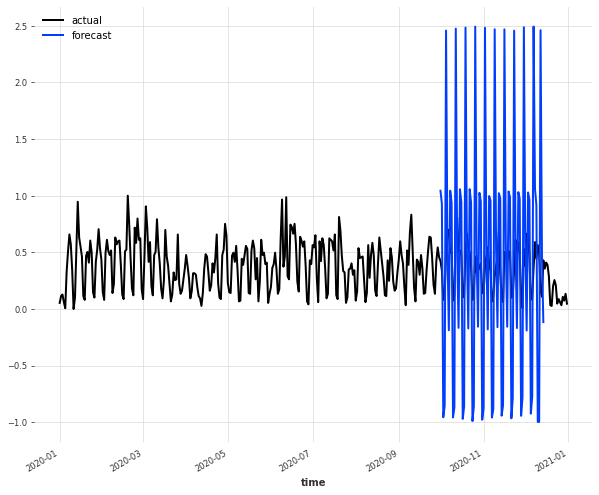

In [40]:
pred_ai = model_ai.predict(n=75, series = train_tweet_count )
#pred_follower = model_ai_multiple.predict(n=36, series = train_follower )
error_tweet = mape(val_tweet_count[:75],pred_ai)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the tweet_count:",error_tweet )
series_ai_count.plot(label='actual')
#val_retweet.plot(label= 'validation')
plt.rcParams['figure.figsize'] = [10, 8]
pred_ai.plot(label='forecast')
fig1 = plt.gcf()
plt.legend();
#fig1.savefig('forecast_75_days.png')
print('MAPE = {:.2f}%'.format(mape(series_ai_count, pred_ai)))


this is the error for the tweet_count: 66.75059846699527
MAPE = 66.75%


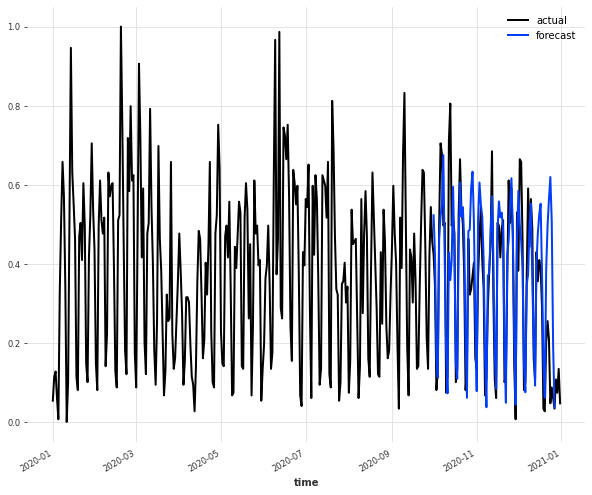

In [ ]:
pred_ai = model_ai.predict(n=88, series = train_tweet_count )
#pred_follower = model_ai_multiple.predict(n=36, series = train_follower )
error_tweet = mape(val_tweet_count[:88],pred_ai)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the tweet_count:",error_tweet )
series_ai_count.plot(label='actual')
#val_retweet.plot(label= 'validation')
plt.rcParams['figure.figsize'] = [10, 8]
pred_ai.plot(label='forecast')
fig1 = plt.gcf()
plt.legend();
fig1.savefig('forecast_88_days.png')
print('MAPE = {:.2f}%'.format(mape(series_ai_count, pred_ai)))

this is the error for the tweet_count: 36.80811405431139
MAPE = 36.81%


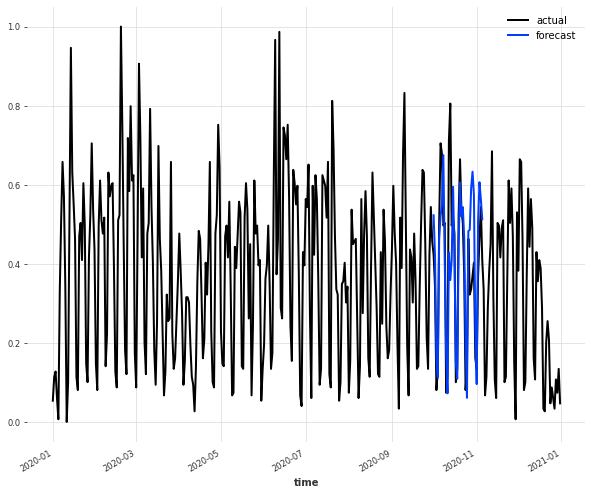

In [ ]:
pred_ai = model_ai.predict(n=36, series = train_tweet_count )
#pred_follower = model_ai_multiple.predict(n=36, series = train_follower )
error_tweet = mape(val_tweet_count[:36],pred_ai)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the tweet_count:",error_tweet )
series_ai_count.plot(label='actual')
#val_retweet.plot(label= 'validation')
plt.rcParams['figure.figsize'] = [10, 8]
pred_ai.plot(label='forecast')
fig1 = plt.gcf()
plt.legend();
fig1.savefig('forecast_36_days.png')
print('MAPE = {:.2f}%'.format(mape(series_ai_count, pred_ai)))

In [ ]:
!pip install pyextremes

In [ ]:
from pyextremes import EVA, __version__
print("pyextremes", __version__)

pyextremes 2.0.0


In [ ]:
pred_ai_60 = model_ai.predict(n=60, series = train_tweet_count )
pred_ai_36 = model_ai.predict(n=36, series = train_tweet_count )
pred_ai_75 = model_ai.predict(n=75, series = train_tweet_count )

In [ ]:
pred_ai_36

<TimeSeries (DataArray) (time: 36, component: 1, sample: 1)>
array([[[0.52262162]],

       [[0.42097409]],

       [[0.15978732]],

       [[0.11200833]],

       [[0.46484952]],

       [[0.52032965]],

       [[0.55052553]],

       [[0.67488611]],

       [[0.40757884]],

       [[0.17716671]],

...

       [[0.48583842]],

       [[0.59118893]],

       [[0.63295929]],

       [[0.57436429]],

       [[0.23003742]],

       [[0.09570596]],

       [[0.50675528]],

       [[0.60638263]],

       [[0.56282209]],

       [[0.51252179]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-10-01 2020-10-02 ... 2020-11-05
  * component  (component) object 'count'
Dimensions without coordinates: sample

In [ ]:
 series_pred_36= pred_ai_36.pd_series()
 series_pred_36

time
2020-10-01    0.522622
2020-10-02    0.420974
2020-10-03    0.159787
2020-10-04    0.112008
2020-10-05    0.464850
2020-10-06    0.520330
2020-10-07    0.550526
2020-10-08    0.674886
2020-10-09    0.407579
2020-10-10    0.177167
2020-10-11    0.072428
2020-10-12    0.428333
2020-10-13    0.358850
2020-10-14    0.409066
2020-10-15    0.594917
2020-10-16    0.419050
2020-10-17    0.148580
2020-10-18    0.109191
2020-10-19    0.443237
2020-10-20    0.605739
2020-10-21    0.520064
2020-10-22    0.543433
2020-10-23    0.466328
2020-10-24    0.199507
2020-10-25    0.060956
2020-10-26    0.482824
2020-10-27    0.485838
2020-10-28    0.591189
2020-10-29    0.632959
2020-10-30    0.574364
2020-10-31    0.230037
2020-11-01    0.095706
2020-11-02    0.506755
2020-11-03    0.606383
2020-11-04    0.562822
2020-11-05    0.512522
Freq: D, dtype: float64

In [ ]:
model = EVA(data= series_pred_36)

/usr/local/lib/python3.7/dist-packages/pyextremes/eva.py:84: FutureWarning:

Index.is_all_dates is deprecated, will be removed in a future version.  check index.inferred_type instead



In [ ]:
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size= pd.Timedelta("15 days"),
    errors="raise",
)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                                  36
Start:                       October 2020      End:                        November 2020
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                  3      Extraction method:                     BM
Type:                                high      Block size:              15 days 00:00:00
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='extreme values'>)

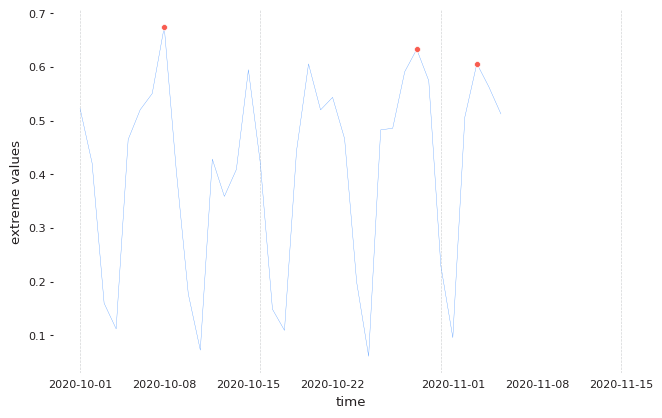

In [ ]:
model.plot_extremes()


In [ ]:
 series_pred_60= pred_ai_60.pd_series()
 series_pred_75 = pred_ai_75.pd_series()

In [ ]:
model_60 = EVA(data= series_pred_60)
model_75 = EVA(data= series_pred_75)

In [ ]:
model_60.get_extremes(
    method="BM",
    extremes_type="high",
    block_size= pd.Timedelta("15 days"),
    errors="raise",
)
model_75.get_extremes(
    method="BM",
    extremes_type="high",
    block_size= pd.Timedelta("15 days"),
    errors="raise",
)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='extreme values'>)

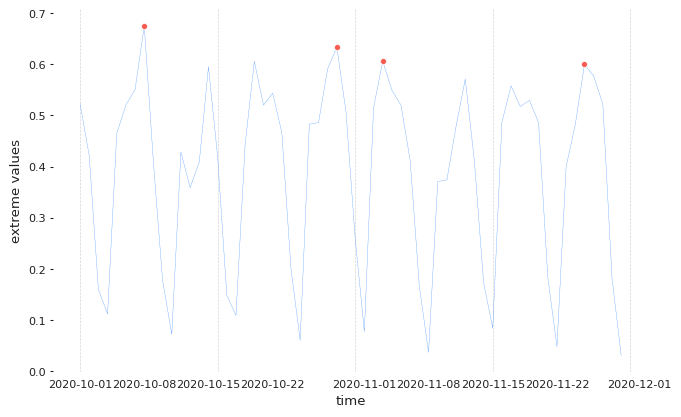

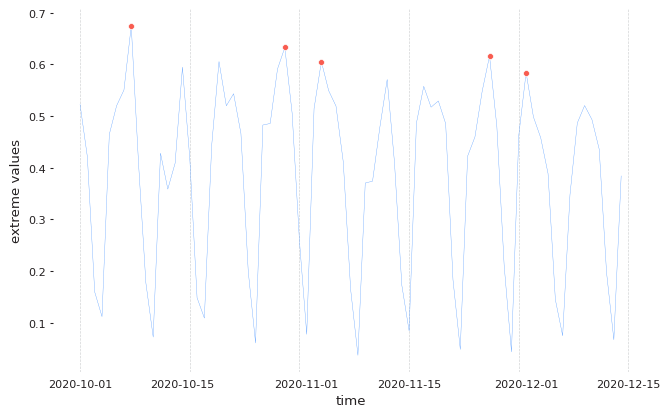

In [ ]:
model_60.plot_extremes()
model_75.plot_extremes()